# **Setting up the Environment**

All the necessary paths for datasets on drive and jdk are passed. 
Also all the required libraries are installed and imported along with configuration of spark context for future use.


In [ ]:
# Mounting the google drive for easy access of the dataset 
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
# Path for Java
JAVA_HOME = "/usr/lib/jvm/java-8-openjdk-amd64"

#**PySpark implementation**

In [ ]:
!pip install pyspark
!pip install -U -q PyDrive
!apt install openjdk-8-jdk-headless -qq
import os
os.environ["JAVA_HOME"] = JAVA_HOME

     |████████████████████████████████| 204.7MB 66kB/s 
     |████████████████████████████████| 204kB 44.0MB/s 
  Created wheel for pyspark: filename=pyspark-3.0.0-py2.py3-none-any.whl size=205044182 sha256=acf76f71a021f2ee1ba022b4b66230d85396afb07c5365eee278266cd89840de
  Stored in directory: /root/.cache/pip/wheels/57/27/4d/ddacf7143f8d5b76c45c61ee2e43d9f8492fc5a8e78ebd7d37
Successfully built pyspark
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  openjdk-8-jre-headless
Suggested packages:
  openjdk-8-demo openjdk-8-source libnss-mdns fonts-dejavu-extra
  fonts-ipafont-gothic fonts-ipafont-mincho fonts-wqy-microhei
  fonts-wqy-zenhei fonts-indic
The following NEW packages will be installed:
  openjdk-8-jdk-headless openjdk-8-jre-headless
0 upgraded, 2 newly installed, 0 to remove and 33 not upgraded.
Need to get 35.8 MB of archives.
After this 

In [ ]:
# Installing and importing the required python libraries
import requests
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time
%matplotlib inline

import pyspark
from pyspark.sql import *
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark import SparkContext, SparkConf

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# import the SparkConfiguration and SparkContext
# if we wanted to change any configuration settings for this session only we would define them here
conf = (SparkConf()
        .setMaster("local")
        .setAppName("Recommender_System")
        .set("spark.executor.memory", "16G")
        .set("spark.driver.memory", "16G")
        .set("spark.executor.cores", "8"))
# create a SparkContext using the above configuration
sc = SparkContext(conf=conf)
spark = SparkSession.builder.getOrCreate()

In [ ]:
spark

In [ ]:
# this command shows the current configuration settings
sc._conf.getAll()

[('spark.master', 'local'),
 ('spark.driver.memory', '16G'),
 ('spark.driver.host', 'a9c6d3e698a5'),
 ('spark.executor.id', 'driver'),
 ('spark.driver.port', '42697'),
 ('spark.executor.memory', '16G'),
 ('spark.rdd.compress', 'True'),
 ('spark.app.id', 'local-1593720860074'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.submit.pyFiles', ''),
 ('spark.app.name', 'Recommender_System'),
 ('spark.submit.deployMode', 'client'),
 ('spark.executor.cores', '8'),
 ('spark.ui.showConsoleProgress', 'true')]

# **Loading the Dataset**

Let's read the Movie and TV ratings dataset from the Google drive and do a quick inspection of the dataset

In [ ]:
# read in the dataset from google drive
rating = spark.read.load("/content/drive/My Drive/Ratings_Movies_and_TV.csv", 
                         format="csv", 
                         inferSchema="true", 
                         header="false"
                         )

In [ ]:
# number of rows in the dataset
rating.count()

8765568

In [ ]:
# Printing the head of dataset 
rating.show()

+----------+--------------+---+----------+
|       _c0|           _c1|_c2|       _c3|
+----------+--------------+---+----------+
|0001527665|A3478QRKQDOPQ2|5.0|1362960000|
|0001527665|A2VHSG6TZHU1OB|5.0|1361145600|
|0001527665|A23EJWOW1TLENE|5.0|1358380800|
|0001527665|A1KM9FNEJ8Q171|5.0|1357776000|
|0001527665|A38LY2SSHVHRYB|4.0|1356480000|
|0001527665| AHTYUW2H1276L|5.0|1353024000|
|0001527665|A3M3HCZLXW0YLF|5.0|1342310400|
|0001527665|A1OMHX76O2NC6V|1.0|1283472000|
|0001527665|A3OBOZ41IK6O1M|1.0|1273190400|
|0005089549|A2M1CU2IRZG0K9|5.0|1352419200|
|0005089549|A1XIXLXK9B4DAJ|5.0|1347321600|
|0005089549| AFTUJYISOFHY6|5.0|1325203200|
|0005089549| AEIAQFCWNRUSE|5.0|1301702400|
|0005089549|A16WO8T4YXGVWP|5.0|1277596800|
|0005089549| AX7ANRP31Q7YA|5.0|1240272000|
|0005089549| AIPN1XFK37ZWI|5.0| 933984000|
|000503860X| A7H20K09VIXXT|4.0|1123891200|
|000503860X|A2LGI22B6XRZVA|5.0|1123286400|
|000503860X|A2A4GWAEM3VOW0|5.0|1116374400|
|000503860X|A226BMXAQAJVOQ|5.0|1115942400|
+----------

In [ ]:
# Renaming the columns of the dataset for Easy reference
ratings = rating.select(col("_c0").alias("UserId"), col("_c1").alias("MovieId"),col("_c2").alias("Rating"),col("_c3").alias("Timestamp"))
ratings.show()

+----------+--------------+------+----------+
|    UserId|       MovieId|Rating| Timestamp|
+----------+--------------+------+----------+
|0001527665|A3478QRKQDOPQ2|   5.0|1362960000|
|0001527665|A2VHSG6TZHU1OB|   5.0|1361145600|
|0001527665|A23EJWOW1TLENE|   5.0|1358380800|
|0001527665|A1KM9FNEJ8Q171|   5.0|1357776000|
|0001527665|A38LY2SSHVHRYB|   4.0|1356480000|
|0001527665| AHTYUW2H1276L|   5.0|1353024000|
|0001527665|A3M3HCZLXW0YLF|   5.0|1342310400|
|0001527665|A1OMHX76O2NC6V|   1.0|1283472000|
|0001527665|A3OBOZ41IK6O1M|   1.0|1273190400|
|0005089549|A2M1CU2IRZG0K9|   5.0|1352419200|
|0005089549|A1XIXLXK9B4DAJ|   5.0|1347321600|
|0005089549| AFTUJYISOFHY6|   5.0|1325203200|
|0005089549| AEIAQFCWNRUSE|   5.0|1301702400|
|0005089549|A16WO8T4YXGVWP|   5.0|1277596800|
|0005089549| AX7ANRP31Q7YA|   5.0|1240272000|
|0005089549| AIPN1XFK37ZWI|   5.0| 933984000|
|000503860X| A7H20K09VIXXT|   4.0|1123891200|
|000503860X|A2LGI22B6XRZVA|   5.0|1123286400|
|000503860X|A2A4GWAEM3VOW0|   5.0|

# **Data Exploration**

Let's investigate the data and try to find and make some observations by looking at summary statistics
  

In [ ]:
print ('Distinct values of ratings:')
print (ratings.select('Rating').distinct().rdd.map(lambda r: r[0]).collect())

Distinct values of ratings:
[1.0, 4.0, 3.0, 2.0, 5.0]


In [ ]:
tmp1 = ratings.groupBy("UserId").count().select('count').rdd.min()[0]
tmp2 = ratings.groupBy("MovieId").count().select('count').rdd.min()[0]
print ('For the users that rated movies and the movies that were rated:')
print ('Minimum number of ratings per User is {}'.format(tmp1))
print ('Minimum number of ratings per Movie is {}'.format(tmp2))

For the users that rated movies and the movies that were rated:
Minimum number of ratings per User is 1
Minimum number of ratings per Movie is 1


In [ ]:
tmp1 = ratings.groupBy("movieId").count().withColumnRenamed("count", "rating count")\
.groupBy("rating count").count().orderBy('rating count').first()[1]
# Or use pandas: tmp1 = sum(ratings.groupBy("movieId").count().toPandas()['count'] == 1)
tmp2 = ratings.select('movieId').distinct().count()
print ('{} out of {} movies are rated by only one user'.format(tmp1, tmp2))

2429325 out of 3826085 movies are rated by only one user


In [ ]:
print ("Number of users who rated movies:", ratings.select('UserId').distinct().count())
print ("Number of rated movies:", ratings.select('MovieId').distinct().count())

Number of users who rated movies: 182032
Number of rated movies: 3826085


**Summary of Descriptive Statistics**

In [ ]:
ratings.describe().toPandas()

,summary,UserId,MovieId,Rating,Timestamp
0,count,8765568,8765568,8765568,8765568
1,mean,5.482090734266104E9,None,4.2330105704501975,1.3913399532198713E9
2,stddev,2.0830512994750547E9,None,1.2214384170934065,1.1170639662611073E8
3,min,0000143502,A00013803RVZPCZKTT9U,1.0,871948800
4,max,B01HJF79XO,AZZZYAYJQSDOJ,5.0,1538524800


Converting Spark data to well-known Pandas could be done easily with toPandas() method:

In [ ]:
# To access plotting libraries, we need to first transform our PySpark DataFrame into a Pandas DataFrame
Ratings_pdf = ratings.toPandas() 

**Analysis of Rating Distributions**

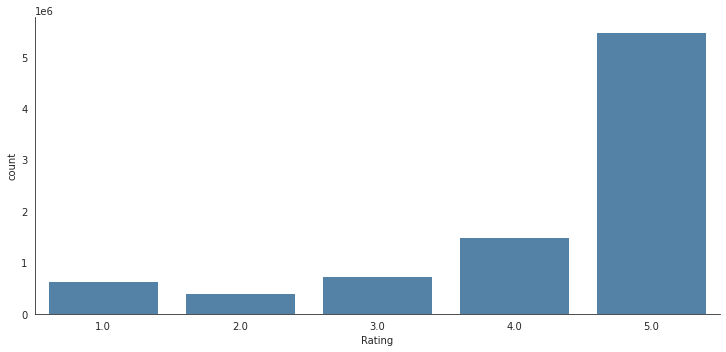

In [ ]:
with sns.axes_style('white'):
    g = sns.catplot("Rating",
                data=Ratings_pdf,
               kind="count", aspect=2,color='steelblue')
     

<Figure size 864x720 with 0 Axes>

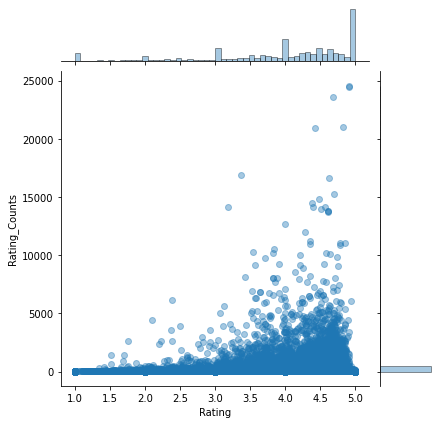

In [ ]:
Ratings_pdf_mean_counts = pd.DataFrame(Ratings_pdf.groupby('MovieId')['Rating'].mean())
Ratings_pdf_mean_counts['Rating_Counts'] = pd.DataFrame(Ratings_pdf.groupby('MovieId')['Rating'].count())

plt.figure(figsize=(12,10))
plt.rcParams['patch.force_edgecolor'] = True
sns.jointplot(x='Rating', y='Rating_Counts', data=Ratings_pdf_mean_counts, alpha=0.4)

# **Sampling**

Here I have decided to take a sample of the dataset for recommendation as the entire dataset is quite huge and implementing various ML techniques like model training, hyperparameter tuning etc. is difficult on free/local resources without crashing

I have use stratified sampling to have the best unbiased sample with appropriate size

In [ ]:
ratings.groupBy("MovieId").count().show()

+--------------+-----+
|       MovieId|count|
+--------------+-----+
| AVIKFXS6MT2YV|    2|
|A3826GI7UHI7SZ|    9|
|A33GM0OUOWK19O|    1|
|A1687MV0PLK74B|   16|
| AB64DUL65WO6O|   10|
|A1FWW47TZ65PNY|    1|
|A3RJ48YJJ3NOII|   18|
|A1M0G9T633G1C3|    5|
|A2QVL8FGY79WWH|    3|
|A20TI7T43DCSRY|    2|
|A343A2TZEZ9Y86|    1|
| A6GMEO3VRY51S|  207|
|A2DNWSXNZBD204|   23|
| AZS14W9Q9XCUQ|    8|
| AX3NVXGCTQ8AN|    1|
| AYMM8AP7UVA8Y|    1|
|A2E130DG40UA2L|   17|
| ASWG8EJHCWPKC|   21|
|A1UFEP3IOALM8V|    1|
|A2BUPLL6RIQBRB|    1|
+--------------+-----+
only showing top 20 rows



In [ ]:
fractions = ratings.select("MovieId").distinct().withColumn("fraction", lit(0.7)).rdd.collectAsMap()
print(fractions)                                                            
sampled_ratings = ratings.stat.sampleBy("MovieId", fractions, seed=1234)
sampled_ratings.show()

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



+----------+--------------+------+----------+
|    UserId|       MovieId|Rating| Timestamp|
+----------+--------------+------+----------+
|0001527665|A23EJWOW1TLENE|   5.0|1358380800|
|0001527665|A1KM9FNEJ8Q171|   5.0|1357776000|
|0001527665| AHTYUW2H1276L|   5.0|1353024000|
|0001527665|A3M3HCZLXW0YLF|   5.0|1342310400|
|0001527665|A1OMHX76O2NC6V|   1.0|1283472000|
|0001527665|A3OBOZ41IK6O1M|   1.0|1273190400|
|0005089549|A2M1CU2IRZG0K9|   5.0|1352419200|
|0005089549|A1XIXLXK9B4DAJ|   5.0|1347321600|
|0005089549| AFTUJYISOFHY6|   5.0|1325203200|
|0005089549| AEIAQFCWNRUSE|   5.0|1301702400|
|0005089549|A16WO8T4YXGVWP|   5.0|1277596800|
|0005089549| AX7ANRP31Q7YA|   5.0|1240272000|
|0005089549| AIPN1XFK37ZWI|   5.0| 933984000|
|000503860X| A7H20K09VIXXT|   4.0|1123891200|
|000503860X|A2LGI22B6XRZVA|   5.0|1123286400|
|000503860X|A2A4GWAEM3VOW0|   5.0|1116374400|
|000503860X|A226BMXAQAJVOQ|   5.0|1115942400|
|000503860X| AIL0Y2OUE1680|   5.0|1115942400|
|000503860X|A12VPEOEZS1KTC|   5.0|

In [ ]:
sampled_ratings.count()

6137221

In [ ]:
sampled_ratings.groupBy("MovieId").count().show()

+--------------+-----+
|       MovieId|count|
+--------------+-----+
|A3826GI7UHI7SZ|    7|
|A33GM0OUOWK19O|    1|
|A1687MV0PLK74B|   13|
| AB64DUL65WO6O|    9|
|A1FWW47TZ65PNY|    1|
|A1M0G9T633G1C3|    2|
|A2QVL8FGY79WWH|    2|
|A20TI7T43DCSRY|    2|
| A6GMEO3VRY51S|  143|
| AYMM8AP7UVA8Y|    1|
| ASWG8EJHCWPKC|   15|
|A1UFEP3IOALM8V|    1|
|A39VS8820WCN0G|    7|
| ANEDXRFDZDL18|  161|
| A8PL5OAS7IWKR|   21|
|A1GX7WCR2HBXNH|   11|
|A3NYF46FNW70VP|    1|
|A3510KIIRV4KZV|    1|
|A1KHZXNXZS8EUN|    1|
|A2DWUZLALBWVM6|    2|
+--------------+-----+
only showing top 20 rows



Converting Spark data to well-known Pandas could be done easily with toPandas() method:

In [ ]:
# To access plotting libraries, we need to first transform our PySpark DataFrame into a Pandas DataFrame
Rating_pdf = sampled_ratings.toPandas() 

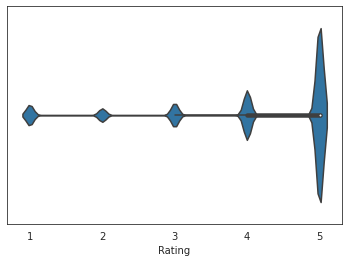

In [ ]:
with sns.axes_style('white'):
     ax = sns.violinplot(x=Ratings_pdf["Rating"])

<Figure size 864x720 with 0 Axes>

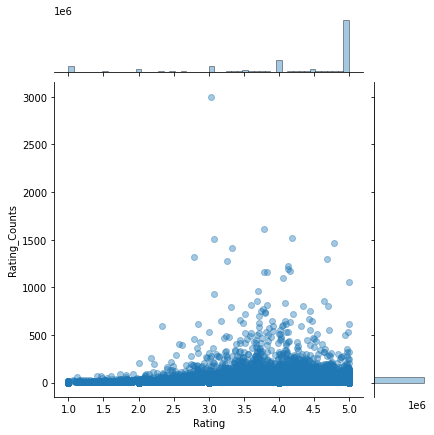

In [ ]:
Rating_pdf_mean_counts = pd.DataFrame(Rating_pdf.groupby('MovieId')['Rating'].mean())
Rating_pdf_mean_counts['Rating_Counts'] = pd.DataFrame(Rating_pdf.groupby('MovieId')['Rating'].count())

plt.figure(figsize=(12,10))
plt.rcParams['patch.force_edgecolor'] = True
sns.jointplot(x='Rating', y='Rating_Counts', data=Rating_pdf_mean_counts, alpha=0.4)

# **Data Pre-processing**

The data is processed to have the right set of variables and its types for implementing the ML algorithm, in our case it is Alternating Least Square (ALS) which recommends using Collaborative filtering

In [ ]:
Ratings = sampled_ratings.select("UserId", "MovieId", "Rating")

In [ ]:
# inspect the schema of the data frame
Ratings.printSchema()

root
 |-- UserId: string (nullable = true)
 |-- MovieId: string (nullable = true)
 |-- Rating: double (nullable = true)



In [ ]:
# The userId and movieId have to be integers or double, and the rating has to be float/double numbers.
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer

indexers = [StringIndexer(inputCol=column, outputCol=column+"_index").fit(Ratings) for column in list(set(Ratings.columns)-set(['Rating'])) ]


pipeline = Pipeline(stages=indexers)
Ratings_df = pipeline.fit(Ratings).transform(Ratings)

Ratings_df.show() 

+----------+--------------+------+-------------+------------+
|    UserId|       MovieId|Rating|MovieId_index|UserId_index|
+----------+--------------+------+-------------+------------+
|0001527665|A23EJWOW1TLENE|   5.0|    1572690.0|     44694.0|
|0001527665|A1KM9FNEJ8Q171|   5.0|     553740.0|     44694.0|
|0001527665| AHTYUW2H1276L|   5.0|    2756451.0|     44694.0|
|0001527665|A3M3HCZLXW0YLF|   5.0|     824414.0|     44694.0|
|0001527665|A1OMHX76O2NC6V|   1.0|    1350975.0|     44694.0|
|0001527665|A3OBOZ41IK6O1M|   1.0|    2429282.0|     44694.0|
|0005089549|A2M1CU2IRZG0K9|   5.0|     368343.0|     39345.0|
|0005089549|A1XIXLXK9B4DAJ|   5.0|    1485046.0|     39345.0|
|0005089549| AFTUJYISOFHY6|   5.0|     272548.0|     39345.0|
|0005089549| AEIAQFCWNRUSE|   5.0|    2706410.0|     39345.0|
|0005089549|A16WO8T4YXGVWP|   5.0|     197473.0|     39345.0|
|0005089549| AX7ANRP31Q7YA|   5.0|    2987424.0|     39345.0|
|0005089549| AIPN1XFK37ZWI|   5.0|    2769622.0|     39345.0|
|0005038

In [ ]:
Ratings_df = Ratings_df.drop('UserId','MovieId')

In [ ]:
# inspect the schema again
Ratings_df.printSchema()

root
 |-- Rating: double (nullable = true)
 |-- MovieId_index: double (nullable = false)
 |-- UserId_index: double (nullable = false)



**Extracting the stratified sampling file "sample_ratings" and save the file in the drive**

In [ ]:
Ratings_df.coalesce(1).write.csv('/content/drive/My Drive/sample_ratings.csv')


**Loading the sampled dataset**

Let's read the Movie and TV ratings dataset from the Google drive and do a quick inspection of the dataset


In [ ]:
# read in the dataset from google drive
ratings_df = spark.read.load("/content/drive/My Drive/sample_ratings.csv", 
                         format="csv", 
                         inferSchema="true", 
                         header="false"
                         )

In [ ]:
# number of rows in the dataset
ratings_df.count()

6137221

In [ ]:
# Printing the head of dataset 
ratings_df.show()

+---+---------+-------+
|_c0|      _c1|    _c2|
+---+---------+-------+
|5.0|1572690.0|44694.0|
|5.0| 553740.0|44694.0|
|5.0|2756451.0|44694.0|
|5.0| 824414.0|44694.0|
|1.0|1350975.0|44694.0|
|1.0|2429282.0|44694.0|
|5.0| 368343.0|39345.0|
|5.0|1485046.0|39345.0|
|5.0| 272548.0|39345.0|
|5.0|2706410.0|39345.0|
|5.0| 197473.0|39345.0|
|5.0|2987424.0|39345.0|
|5.0|2769622.0|39345.0|
|4.0| 874585.0|36530.0|
|5.0|1844208.0|36530.0|
|5.0| 647867.0|36530.0|
|5.0|1554177.0|36530.0|
|5.0| 915540.0|36530.0|
|5.0|   9387.0|36530.0|
|5.0|  22466.0|36530.0|
+---+---------+-------+
only showing top 20 rows



In [ ]:
# Renaming the columns of the dataset for Easy reference
ratings_df = ratings_df.select(col("_c0").alias("Rating"), col("_c1").alias("MovieId_index"),col("_c2").alias("UserId_index"))
ratings_df.show()

+------+-------------+------------+
|Rating|MovieId_index|UserId_index|
+------+-------------+------------+
|   5.0|    1572690.0|     44694.0|
|   5.0|     553740.0|     44694.0|
|   5.0|    2756451.0|     44694.0|
|   5.0|     824414.0|     44694.0|
|   1.0|    1350975.0|     44694.0|
|   1.0|    2429282.0|     44694.0|
|   5.0|     368343.0|     39345.0|
|   5.0|    1485046.0|     39345.0|
|   5.0|     272548.0|     39345.0|
|   5.0|    2706410.0|     39345.0|
|   5.0|     197473.0|     39345.0|
|   5.0|    2987424.0|     39345.0|
|   5.0|    2769622.0|     39345.0|
|   4.0|     874585.0|     36530.0|
|   5.0|    1844208.0|     36530.0|
|   5.0|     647867.0|     36530.0|
|   5.0|    1554177.0|     36530.0|
|   5.0|     915540.0|     36530.0|
|   5.0|       9387.0|     36530.0|
|   5.0|      22466.0|     36530.0|
+------+-------------+------------+
only showing top 20 rows



# **Splitting the dataset into Train and Test**

I will split the data into training/testing sets using a 80/20 random splits.
This is done to Train the model on train set and finally evaluate the model post predicting on the test set

In [ ]:
(train, test) = ratings_df.randomSplit([0.8, 0.2])

In [ ]:
print ("The number of ratings in each set: {}, {}".format(train.count(), test.count()))

The number of ratings in each set: 4910969, 1226252


# **Alternating Least Squares (ALS)**

Let's take a look on parameters, and try to find any improvements.

Parameters of ALS Model in PySpark realization are following:



*   **NumBlocks** is the number of blocks the users and items will be partitioned intoin order to parallelize computation.(set to -1 to auto-configure).
*   **rank** is the number of latent factors in the model.

*   **maxIter** is the maximum number of iterations to run.

*   **regParam** specifies the regularization parameter in ALS.
*   **implicitPrefs** specifies whether to use the explicit feedback ALS variant or one adapted for implicit feedback data (defaults to false which means using explicit feedback).
*   **alpha** is a parameter applicable to the implicit feedback variant of ALS that governs the baseline confidence in preference observations (defaults to 1.0).

In [ ]:
# Build the recommendation model using ALS on the training data
# Note we set cold start strategy to 'drop' to ensure we don't get NaN evaluation metrics
from pyspark.ml.recommendation import ALS
als = ALS(rank = 25, maxIter=5, regParam=0.01, 
          userCol="UserId_index", itemCol="MovieId_index", ratingCol="Rating",
          coldStartStrategy="drop",
          implicitPrefs=True)


In [ ]:
# fit the model to the training data
model = als.fit(train) 

#**Make predictions on test_data**

In [ ]:
predictions_als = model.transform(test)

# View the predictions 
predictions_als.show()

+------+-------------+------------+-----------+
|Rating|MovieId_index|UserId_index| prediction|
+------+-------------+------------+-----------+
|   5.0|        148.0|       458.0| 0.39505172|
|   3.0|        148.0|     12322.0|0.039479308|
|   5.0|        148.0|       155.0| 0.34969345|
|   3.0|        148.0|      1700.0| 0.28224003|
|   5.0|        148.0|      1226.0| 0.26553732|
|   5.0|        148.0|     11677.0| 0.22716017|
|   5.0|        148.0|       908.0|  0.5086603|
|   5.0|        148.0|       916.0| 0.14837763|
|   3.0|        148.0|      3037.0| 0.07306489|
|   5.0|        148.0|      4363.0|0.108396456|
|   5.0|        148.0|      7742.0| 0.15486585|
|   3.0|        148.0|     14032.0|0.049149938|
|   5.0|        148.0|       246.0| 0.18326698|
|   4.0|        148.0|       861.0| 0.54574233|
|   5.0|        148.0|      6350.0|  0.0642322|
|   5.0|        148.0|      2466.0| 0.23370916|
|   3.0|        148.0|      1599.0| 0.22250427|
|   4.0|        148.0|      4515.0| 0.24

#**Evaluate the predictions**

Evaluate the model by computing the RMSE on the test data

In [ ]:
# Evaluate the model by computing the RMSE on the test data
from pyspark.ml.evaluation import RegressionEvaluator

evaluator = RegressionEvaluator(metricName="rmse", labelCol="Rating",
                                predictionCol="prediction")

rmse = evaluator.evaluate(predictions_als)
print("Root-mean-square error = " + str(rmse)) 

Root-mean-square error = 4.361782907696021


#**Evaluate the predictions**
Evaluate the model by computing the MAE on the test data

In [ ]:
# instantiate evaluator, specifying the desired metric "mae" and the columns
# that contain the predictions and the actual values
evaluator = RegressionEvaluator(metricName="mae", predictionCol="prediction", labelCol="Rating")

# evaluate the output of our model
mae = evaluator.evaluate(predictions_als)

print('The Mean Absolute Error is %.3f' % (mae))

The Mean Absolute Error is 4.207


In this we have achieved very high RMSE & MAE score 



#**Parameter Optimization**

#**TrainValidationSplit**


The parameters we will search over are:


*   **Rank** - The number of hidden features that we will use to describe the users/movies.

*   **RegParam** - The regularization parameter applied to the cost function.



**Root Mean Square Error**



In [ ]:
from pyspark.ml.tuning import TrainValidationSplit, ParamGridBuilder
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator

#create a new ALS estimator
als = ALS(userCol="UserId_index", itemCol="MovieId_index", ratingCol="Rating", coldStartStrategy="drop")
#define a grid for both parameters
paramGrid = ParamGridBuilder() \
    .addGrid(als.rank, [5, 10, 15]) \
    .addGrid(als.regParam, [1, 0.1, 0.01]) \
    .build()

In [ ]:
# Define evaluator as RMSE
evaluator = RegressionEvaluator(metricName="rmse", predictionCol="prediction", labelCol="Rating")

In [ ]:
# split the data with a ratio of 80% training, 20% validation
# define the estimator and evaluator to use to determine the best model
# also pass in the parameter grid to search over
trainValSplit = TrainValidationSplit(estimator = als, estimatorParamMaps=paramGrid, 
  evaluator = RegressionEvaluator(metricName="rmse", predictionCol="prediction", labelCol="Rating"), 
  trainRatio = 0.8, parallelism = 4)

In [ ]:
# fit the model to the training data
model = trainValSplit.fit(train)

In [ ]:
# retrieve the best model
bestModel = model.bestModel

Unfortunately there is currently no way in spark to see which combination of hyperparameters were used in the best model. We now use the best model to transform the test data and compute predictions & evaluate.

#**Make predictions on test_data**

In [ ]:
# transform test data using bestModel
predictions = bestModel.transform(test)

# View the predictions 
predictions.show()

+------+-------------+------------+----------+
|Rating|MovieId_index|UserId_index|prediction|
+------+-------------+------------+----------+
|   3.0|        148.0|     12322.0| 3.0732892|
|   4.0|        148.0|     22903.0| 3.5088274|
|   5.0|        148.0|      2044.0| 3.3701227|
|   5.0|        148.0|      1030.0| 3.3683994|
|   4.0|        148.0|     15159.0| 3.2757866|
|   2.0|        148.0|      1244.0| 3.1373582|
|   3.0|        148.0|      3006.0| 3.1929076|
|   5.0|        148.0|     13529.0| 3.1663463|
|   5.0|        148.0|       734.0| 3.3845575|
|   3.0|        148.0|     10877.0|  3.173956|
|   5.0|        148.0|     27199.0| 3.2234533|
|   4.0|        148.0|     10458.0|  3.284251|
|   5.0|        148.0|      3856.0| 3.3899229|
|   1.0|        148.0|     27947.0| 2.8077927|
|   1.0|        148.0|     38498.0| 3.2089317|
|   5.0|        148.0|      8589.0| 3.1504912|
|   3.0|        148.0|      3298.0|  2.987259|
|   5.0|        148.0|      4897.0|  3.238539|
|   5.0|     

#**Evaluate the predictions**
Evaluate the model by computing the RMSE on the test data

In [ ]:
# evaluate the predictions
rmse = evaluator.evaluate(predictions)
print('Root Mean Square Error = ' + str(rmse))

Root Mean Square Error = 1.3249204788516387


# Our RMSE score improved really well over our previous RMSE of 4.361782907696021

#**TrainValidationSplit**
**Mean Absolute Error**

In [ ]:
# Define evaluator as MAE
evaluator = RegressionEvaluator(metricName="mae", predictionCol="prediction", labelCol="Rating")

In [ ]:
# split the data with a ratio of 80% training, 20% validation
# define the estimator and evaluator to use to determine the best model
# also pass in the parameter grid to search over
trainValSplit_1 = TrainValidationSplit(estimator = als, estimatorParamMaps=paramGrid, 
    evaluator = RegressionEvaluator(metricName="mae", predictionCol="prediction", labelCol="Rating"), 
    trainRatio = 0.8, parallelism = 4)

In [ ]:
# fit the model to the training data
model_1 = trainValSplit_1.fit(train)

In [ ]:
# retrieve the best model
bestModel_1 = model_1.bestModel

Unfortunately there is currently no way in spark to see which combination of hyperparameters were used in the best model. We now use the best model to transform the test data and compute predictions & evaluate.

#**Make predictions on test_data**

In [ ]:
# transform test data using bestModel
predictions_1 = bestModel_1.transform(test)

# View the predictions 
predictions_1.show()

+------+-------------+------------+----------+
|Rating|MovieId_index|UserId_index|prediction|
+------+-------------+------------+----------+
|   5.0|        148.0|       458.0| 4.0985966|
|   4.0|        148.0|      3124.0| 4.4277363|
|   5.0|        148.0|      3234.0|   4.64029|
|   2.0|        148.0|      3725.0| 2.7166846|
|   5.0|        148.0|      2191.0|  4.212287|
|   3.0|        148.0|     10877.0| 4.1731853|
|   1.0|        148.0|      9813.0|  4.169053|
|   4.0|        148.0|      1467.0|  4.785465|
|   4.0|        148.0|      3932.0| 4.0899057|
|   1.0|        148.0|     38504.0| 2.6704352|
|   3.0|        148.0|     35924.0| 4.5422373|
|   5.0|        148.0|       545.0|  4.002201|
|   1.0|        148.0|     27947.0| 2.8855164|
|   3.0|        148.0|     30656.0|   4.43265|
|   1.0|        148.0|     38498.0| 3.7581713|
|   5.0|        148.0|      8589.0|  4.236023|
|   1.0|        148.0|      6693.0| 3.9375055|
|   4.0|        148.0|     15711.0| 4.5767956|
|   3.0|     

#**Evaluate the predictions**
Evaluate the model by computing the MAE on the test data

In [ ]:
# evaluate the predictions
mae = evaluator.evaluate(predictions_1)
print('The Mean Absolute Error is %.3f' % (mae))

The Mean Absolute Error is 1.189


Our MAE score improved really well over our previous MAE of 4.027

#**Cross Validation**
**Root Mean Square Error**

In [ ]:
from pyspark.ml.recommendation import ALS
# Build generic ALS model without hyperparameters
als = ALS(userCol="UserId_index", itemCol="MovieId_index", ratingCol="Rating", coldStartStrategy="drop")


In [ ]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator

param_grid = ParamGridBuilder() \
 .addGrid(als.rank, [10, 25]) \
 .addGrid(als.maxIter, [10]) \
 .addGrid(als.regParam, [.01, .1]) \
 .build() 
# Define evaluator as RMSE
evaluator = RegressionEvaluator(metricName="rmse", labelCol="Rating",
                                predictionCol="prediction")

# Print length of evaluator
print ("Num models to be tested using param_grid: ", len(param_grid))

Num models to be tested using param_grid:  4


In [ ]:
# Build cross validation step using CrossValidator
cv = CrossValidator(estimator = als,
estimatorParamMaps = param_grid,
evaluator = evaluator,
numFolds = 5)

# Run the cv on the training data
cv_model = cv.fit(train)
# Extract best combination of values from cross validation
best_model = cv_model.bestModel

Unfortunately there is currently no way in spark to see which combination of hyperparameters were used in the best model. We now use the best model to transform the test data and compute predictions & evaluate.

#**Make predictions on test_data**

In [ ]:
# Generate test set predictions and evaluate using RMSE
predictions_2 = best_model.transform(test)

# View the predictions 
predictions_2.show()

+------+-------------+------------+----------+
|Rating|MovieId_index|UserId_index|prediction|
+------+-------------+------------+----------+
|   5.0|        148.0|       918.0| 3.4595466|
|   4.0|        148.0|      3124.0| 4.0765095|
|   5.0|        148.0|      2907.0|  4.050404|
|   5.0|        148.0|      2044.0|  4.590904|
|   4.0|        148.0|       412.0| 4.3416543|
|   3.0|        148.0|        76.0| 3.2247398|
|   4.0|        148.0|     20403.0|  4.263033|
|   5.0|        148.0|      1148.0|  3.085285|
|   3.0|        148.0|      3037.0|  3.494959|
|   4.0|        148.0|       548.0| 4.1852612|
|   5.0|        148.0|      3502.0|  4.362046|
|   5.0|        148.0|      4363.0| 3.6964378|
|   5.0|        148.0|      6350.0|  3.918004|
|   4.0|        148.0|     15159.0|   3.79642|
|   5.0|        148.0|      2466.0| 3.5998642|
|   4.0|        148.0|      2829.0| 3.7341557|
|   2.0|        148.0|      2296.0| 3.6550403|
|   4.0|        148.0|     15725.0| 4.1780167|
|   5.0|     

#**Evaluate the predictions**
Evaluate the model by computing the RMSE on the test data

In [ ]:
rmse = evaluator.evaluate(predictions_2)
# Print evaluation metrics and model parameters
print("**Best Model**")
print("Root Mean Square Error: {:.3f}".format(rmse))
print("RegParam: "), best_model._java_obj.parent().getRegParam()

**Best Model**
Root Mean Square Error: 1.562
RegParam: 


(None, 0.1)

Our RMSE score is improved a bit over our previous RMSE

#**Cross Validation**

**Mean Absolute Error**

In [ ]:
from pyspark.ml.recommendation import ALS
# Build generic ALS model without hyperparameters
als = ALS(userCol="UserId_index", itemCol="MovieId_index", ratingCol="Rating", coldStartStrategy="drop")


In [ ]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator

param_grid = ParamGridBuilder() \
 .addGrid(als.rank, [10, 25]) \
 .addGrid(als.maxIter, [10]) \
 .addGrid(als.regParam, [.01, .1]) \
 .build()
# Define evaluator as MAE
evaluator = RegressionEvaluator(metricName="mae", labelCol="Rating",
                                predictionCol="prediction")

# Print length of evaluator
print ("Num models to be tested using param_grid: ", len(param_grid))

Num models to be tested using param_grid:  4


In [ ]:
# Build cross validation step using CrossValidator
cv_1 = CrossValidator(estimator = als,
estimatorParamMaps = param_grid,
evaluator = evaluator,
numFolds = 5)

# Run the cv on the training data
cv_model_1 = cv_1.fit(train)
# Extract best combination of values from cross validation
best_model_1 = cv_model_1.bestModel

Unfortunately there is currently no way in spark to see which combination of hyperparameters were used in the best model. We now use the best model to transform the test data and compute predictions & evaluate.

#**Make predictions on test_data**

In [ ]:
# Generate test set predictions and evaluate using MAE
predictions_3 = best_model_1.transform(test)

# View the predictions 
predictions_3.show()

+------+-------------+------------+----------+
|Rating|MovieId_index|UserId_index|prediction|
+------+-------------+------------+----------+
|   5.0|        148.0|      2572.0| 3.9373004|
|   5.0|        148.0|       918.0| 3.8579354|
|   3.0|        148.0|      1675.0| 4.2139797|
|   5.0|        148.0|        81.0| 3.5686483|
|   5.0|        148.0|      1226.0|  4.609841|
|   3.0|        148.0|      1869.0|   4.17163|
|   5.0|        148.0|      2044.0| 4.6245217|
|   5.0|        148.0|      1030.0| 4.5167594|
|   3.0|        148.0|        76.0|  3.432896|
|   5.0|        148.0|      2754.0|   4.27392|
|   5.0|        148.0|     11677.0| 4.3751707|
|   5.0|        148.0|       916.0|  3.806754|
|   1.0|        148.0|       984.0|  3.302636|
|   5.0|        148.0|     20578.0|  4.790682|
|   4.0|        148.0|       548.0|  4.296843|
|   5.0|        148.0|      3502.0| 4.5318446|
|   5.0|        148.0|      6350.0| 4.0237274|
|   3.0|        148.0|      1599.0| 3.8772266|
|   4.0|     

#**Evaluate the predictions**
Evaluate the model by computing the MAE on the test data

In [ ]:
mae = evaluator.evaluate(predictions_3)
# Print evaluation metrics and model parameters
print("**Best Model**")
print("Mean Absolute Error: {:.3f}".format(mae))
print("RegParam: "), best_model_1._java_obj.parent().getRegParam()

**Best Model**
Mean Absolute Error: 1.161
RegParam: 


(None, 0.1)

Our MAE score is improved a bit over our previous MAE

# **Provide top Recommendations to all users**

The best model converged to, with the use of cross validation is used to provide recommendations for all users 

In [ ]:
# Finally, using the best model to make recommendations for users
ALS_recommendations = best_model.recommendForAllUsers(numItems = 10)
ALS_recommendations.show(n = 10) 

+------------+--------------------+
|UserId_index|     recommendations|
+------------+--------------------+
|         148|[[230847, 5.99193...|
|         463|[[378108, 5.98811...|
|         471|[[100760, 5.94824...|
|         496|[[144923, 5.83173...|
|         833|[[217312, 6.21240...|
|        1088|[[137656, 5.77013...|
|        1238|[[217312, 6.09007...|
|        1342|[[18794, 5.541206...|
|        1580|[[58204, 5.744831...|
|        1591|[[173694, 5.76754...|
+------------+--------------------+
only showing top 10 rows

